In [21]:
import logging
import os
import time
import random, math
import argparse

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
#import cc3d
from torch.utils.data import DataLoader
from torch.nn.modules.utils import _triple
from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage import zoom
from skimage.exposure import match_histograms

from network.networks import *
from data.dataset import *

from monai.metrics import DiceMetric, HausdorffDistanceMetric

def set_seed(seed):
    torch.cuda.manual_seed_all(seed)
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

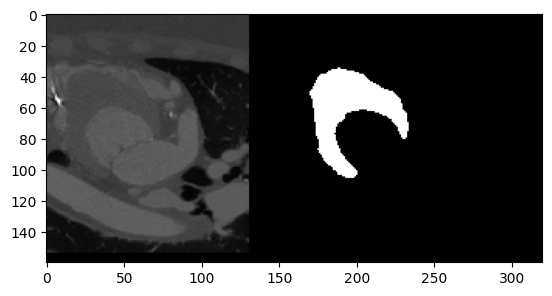

In [22]:
model="HFTrans2"
seed=0
fold_num=19
weight='/home/shqin/cardiac_seg_HFTrans2/checkpoints/latest_checkpoints_HFTrans2_stageTwo_case'$fold_num'_5000_5000.pth'

python ./eval.py \
--dataset /home/shqin/cardiac_seg_HFTrans2/dataset/2channel \
--fold $fold_num \
--patch-size 160 160 160 \
--gpu 3 \
--seed $seed \
--model $model \
--weight $weight \
--tta \
--extention nrrd \
--trained-size 160 \
--resize

patch_size = [160 160 160]
fold = 16
batch_size = 1
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
set_seed(seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if args.model == 'unet':
    config_vit = CONFIGS['BTS']
    model = SimpleUnet(num_channels=64, num_inputs=1, num_outputs=1).to(device)
elif args.model == 'HFTrans':
    config_vit = CONFIGS['BTS']
    model = HFTrans(config_vit, img_size=patch_size, input_channels=1, num_classes=1, vis=False).to(device)
elif args.model == 'HFTrans2':
    config_vit = CONFIGS['HFTrans2']
    model = HFTrans2(config_vit, img_size=patch_size, input_channels=2, num_classes=1, vis=False).to(device)
else:
    print(f'invalid model name {args.model}')
    exit(0)
    model = nn.DataParallel(model)

In [24]:
cv2.imwrite("/home/shqin/CT_sample.jpg", CT)
cv2.imwrite("/home/shqin/label_sample.jpg", label)

True

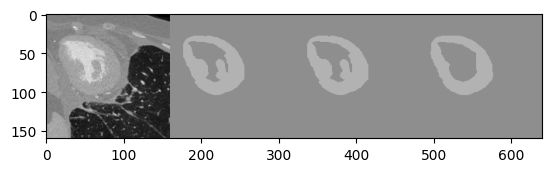

In [23]:
img_ct, _  = nrrd.read("/home/shqin/cardiac_seg_HFTrans2/dataset/2channel/case16/valid/images/case16_ct.nrrd")
label, _  = nrrd.read("/home/shqin/cardiac_seg_HFTrans2/dataset/2channel/case16/valid/labels/case16_label.nrrd")
label_mp, _ = nrrd.read("/home/shqin/cardiac_seg_HFTrans2/dataset/stageOne/valid/labels/case16_label.nrrd")
comb = np.concatenate([img_ct[0, 120, ...],label_mp[120, ...]*255, img_ct[1, 120, ...]* 255, label[120, ...]*255], axis=1)
plt.imshow(comb, cmap="gray")

In [ ]:
imagesTr = glob.glob("/home/shqin/lama/dataset/BMLClosing/imagesTs/*.bmp")
saveDir = "/home/shqin/nnUNet/nnUNetFrame/DATASET/nnUNet_raw/nnUNet_raw_data/Task01_BoneMarrowLession/imagesTs"
os.makedirs(saveDir, exist_ok=True)
for imagePath in imagesTr:
    imgName = os.path.split(imagePath)[-1]
    imageID = imgName.replace("_", "").replace(".bmp", "")
    saveName = "_".join(["OAI", imageID, "0000.bmp"])
    shutil.copy(imagePath, os.path.join(saveDir, saveName))

In [ ]:
imagesTr = glob.glob("/home/shqin/lama/dataset/BMLClosing/labelsTs/*00.bmp")
saveDir = "/home/shqin/nnUNet/nnUNetFrame/DATASET/nnUNet_raw/nnUNet_raw_data/Task01_BoneMarrowLession/labelsTs"
os.makedirs(saveDir, exist_ok=True)
for imagePath in imagesTr:
    imgName = os.path.split(imagePath)[-1]
    imageID = imgName.replace("_", "").replace(".bmp", "")
    saveName = "_".join(["OAI", imageID, ".bmp"])
    BMLName = imagePath
    BoneName = imagePath.replace("_00.bmp", "_01.bmp")
    BML = cv2.imread(BMLName, cv2.IMREAD_GRAYSCALE)
    Bone = cv2.imread(BoneName, cv2.IMREAD_GRAYSCALE)
    mask = np.zeros_like(BML)
    mask[BML>0] = 1
    mask[((BML==0) & (Bone>0))] = 2
    cv2.imwrite(os.path.join(saveDir, saveName), mask)
    # plt.imshow(mask, cmap="gray")
    # print(mask.max(), Bone.max())
    # print(imgName)
    # break
    # shutil.copy(imagePath, os.path.join(saveDir, saveName))

In [ ]:
len(os.listdir("/home/shqin/nnUNet/nnUNetFrame/DATASET/nnUNet_raw/nnUNet_raw_data/Task01_BoneMarrowLession/labelsTs"))

In [ ]:
dataset = {"name": "OAI",
           "description": "Bone marrow lession segmentaion for 2D images",
           "modality": {"0": "BMP"},
           "labels": {
                    "0": "background",
                    "1": "bml",
                    "2": "femur bone"
                    },
            "numTraining": 1215,
            "numTest": 201
           }

In [ ]:
imagePaths = glob.glob("/home/shqin/nnUNet/nnUNetFrame/DATASET/nnUNet_raw/nnUNet_raw_data/Task01_BoneMarrowLession/imagesTr/*.bmp")
train = []
for imagePath in imagePaths:
    temp = {}
    img = "/".join(imagePath.split("/")[-2:])
    label = img.replace("_0000", "").replace("images", "labels")
    temp['image'] = img
    temp['label'] = label
    train.append(temp)

In [ ]:
dataset['training'] = train

In [ ]:
imagePaths = glob.glob("/home/shqin/nnUNet/nnUNetFrame/DATASET/nnUNet_raw/nnUNet_raw_data/Task01_BoneMarrowLession/imagesTs/*.bmp")
test = []
for imagePath in imagePaths:
    temp = {}
    img = "/".join(imagePath.split("/")[-2:])
    label = img.replace("_0000", "").replace("images", "labels")
    temp['image'] = img
    temp['label'] = label
    test.append(temp)

dataset['testing'] = test

In [ ]:
with open("/home/shqin/nnUNet/nnUNetFrame/DATASET/nnUNet_raw/nnUNet_raw_data/Task01_BoneMarrowLession/dataset.json", "w") as f:
    json.dump(dataset, f, indent=4)

In [ ]:
with open("/home/shqin/nnUNet/nnUNetFrame/DATASET/nnUNet_raw/nnUNet_raw_data/Task01_BoneMarrowLession/dataset.pickle", "wb") as f:
    pickle.dump(dataset, f)